In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os


def getProcessingResults(path):
    numMsgsProcessed = []
    timestamp = []
    with open(path+'/logSpark.txt','r') as f:
        line = f.readline()
        while line:
            if line.startswith('Time elapsed '):
                numMsgsProcessed.append(int(line.split(' ')[5]))
                timestamp.append(datetime.fromtimestamp(int(line.split(' ')[2])/1000.0))
            line = f.readline()

    dfSpark = pd.DataFrame({'time':timestamp, 'messagesProcessed': numMsgsProcessed})

    numMsgsSent = []
    timestamp = []
    portMap = {}
    portData = []

    with open(path+'/producerResult.txt','r') as f:
        line = f.readline()
        while line:
            # check if the port on the 
            port = line.split(' ')[7]
            if port not in portMap.keys():
                portMap[port] = len(portMap)
                portData.append([])
                portData[portMap[port]] = [None]*2
                portData[portMap[port]][0] = []
                portData[portMap[port]][1] = []
            index = portMap[port]

            portData[index][1].append(int(line.split(' ')[4]))
            portData[index][0].append(datetime.fromtimestamp(float(line.split(' ')[0])/1000.0))
            line = f.readline()

    df = []
    for i in portData:
        df.append(pd.DataFrame({'time':i[0],'messagesSent':i[1]}))

    dfConcat = df[0]
    for i in range(1, len(df)):
        dfConcat = pd.merge_ordered(dfConcat,df[i],on='time',fill_method='ffill').fillna(0)
        dfConcat['Sum'] = dfConcat['messagesSent_x']+dfConcat['messagesSent_y']
        dfConcat = dfConcat.drop(columns=['messagesSent_x','messagesSent_y'])
        dfConcat = dfConcat.rename(columns={'Sum':'messagesSent'})

    dfProducer = dfConcat

    dfConcat = pd.merge_ordered(dfSpark, dfProducer, on='time', fill_method='ffill').fillna(0)

    return dfConcat

In [2]:
def getResults(path, msgsPerFile):
    folders = os.listdir(path)
    df  = pd.DataFrame()
    for folder in folders:
        dct = {} 
        par = folder.split('_')
        dct['nodes'] = int(par[0])
        dct['port'] = int(par[1])
        dct['time'] = int(par[2])
        dct['execMem'] = par[3]
        dct['batchDur'] = int(par[4])
        if par[5]=='':
            dct['version'] = 0
        else:
            dct['version'] = int(par[5])

        with open(path+folder+'/logSpark.txt','r') as f:
            line = f.readline()
            while line:
                if line.startswith('Number of messages: '):
                    dct['recvMsgs'] = int(line.lstrip('Number of messages: ').strip())
                if line.startswith('Total update time: '):
                    dct['updateTime'] = int(line.lstrip('Total update time: ').strip())
                if line.startswith('Size of the data: '):
                    dct['totalSize'] = int(line.lstrip('Size of the data: ').strip())

                line = f.readline()
        dct['sentMsgs'] = getProcessingResults(path+folder)['messagesSent'].iloc[-1]

        df2 = pd.DataFrame([dct], columns=dct.keys())
        df = pd.concat([df, df2], axis=0)
    return df

In [3]:
def getMonitorData(path, VM):
    dct = {}
    dct['producer'] = 'log_producer.csv'
    dct['master'] = 'log_master.csv'
    dct['slave1'] = 'log_slave1.csv'
    dct['slave2'] = 'log_slave2.csv'
    dct['slave3'] = 'log_slave3.csv'
    dct['slave4'] = 'log_slave4.csv'
    dct['slave5'] = 'log_slave5.csv'
    dct['slave6'] = 'log_slave6.csv'
    # Start and Stop times for Spark Application
    with open(path+'/logSpark.txt','r') as f:
        line = f.readline()
        while line:
            if line.startswith('Application started at: '):
                startTime = datetime.strptime(line.strip('Application started at: ').rstrip(),'%H:%M:%S.%f').time()            
            if line.startswith('Application stopped at: '):
                stopTime = datetime.strptime(line.strip('Application stopped at: ').rstrip(),'%H:%M:%S.%f').time()
                break
            line = f.readline()
    
    with open(path+'/'+dct[VM],'r') as f:
        line = f.readline()
        timestamp = []
        cpu = []
        mem = []
        read_count = []
        write_count = []
        read_bytes = []
        write_bytes = []
        read_time = []
        write_time = []
        bytes_sent = []
        lo_bytes_sent = []
        lo_bytes_recv = []
        lo_packets_sent = []
        lo_packets_recv = []
        lo_errin = []
        lo_errout = []
        lo_dropin = []
        lo_dropout = []
        ens3_bytes_sent = []
        ens3_bytes_recv = []
        ens3_packets_sent = []
        ens3_packets_recv = []
        ens3_errin = []
        ens3_errout = []
        ens3_dropin = []
        ens3_dropout = []
        while line:
            words = line.split(",")
            try:
                timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
            except:
                timestamp.append(datetime.strptime(words[0]+'.0','%H:%M:%S.%f').time())
            cpu.append(float(words[1]))
            mem.append(float(words[2]))        
            read_count.append(int(words[3]))         
            write_count.append(int(words[4]))
            read_bytes.append(int(words[5]))
            write_bytes.append(int(words[6]))
            read_time.append(int(words[7]))
            write_time.append(int(words[8]))
            lo_bytes_sent.append(int(words[9]))
            lo_bytes_recv.append(int(words[10]))
            lo_packets_sent.append(int(words[11]))
            lo_packets_recv.append(int(words[12]))
            lo_errin.append(int(words[13]))
            lo_errout.append(int(words[14]))
            lo_dropin.append(int(words[15]))
            lo_dropout.append(int(words[16]))
            ens3_bytes_sent.append(int(words[17]))
            ens3_bytes_recv.append(int(words[18]))
            ens3_packets_sent.append(int(words[19]))
            ens3_packets_recv.append(int(words[20]))
            ens3_errin.append(int(words[21]))
            ens3_errout.append(int(words[22]))
            ens3_dropin.append(int(words[23]))
            ens3_dropout.append(int(words[24]))
            line = f.readline()

        for i in range(len(timestamp)):
            if timestamp[i] < startTime:
                start = i+1
            if timestamp[i] > stopTime:
                end = i-1
                break
        df = pd.DataFrame({'time':timestamp[start:end+1],'cpu':cpu[start:end+1], 'mem':mem[start:end+1],
                          'read_count': [read_count[i]-read_count[i-1] for i in range(start,end+1)], 
                           'write_count': [write_count[i]-write_count[i-1] for i in range(start, end+1)],
                          'read_bytes':[read_bytes[i]-read_bytes[i-1] for i in range(start, end+1)],
                          'write_bytes':[write_bytes[i]-write_bytes[i-1] for i in range(start, end+1)],
                           'read_time': [read_time[i]-read_time[i-1] for i in range(start, end+1)],
                           'write_time': [write_time[i]-write_time[i-1] for i in range(start, end+1)],
                           'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(start, end+1)]
                          })
        
        return df


In [4]:
def getQueue(path):
    df = getProcessingResults(path)
    time = df['time']
    timeDelta = [(time[i]-time[0]).value for i in range(0,len(time))]
    df['time'] = timeDelta
    df['queue'] = df['messagesSent']-df['messagesProcessed']
    df = df.drop(columns=['messagesSent', 'messagesProcessed'])
    return df

In [5]:
def getLatency(path):
    dfConcat = getProcessingResults(path)
    time = dfConcat['time']
    messagesProcessed = dfConcat['messagesProcessed']
    messagesProcessed = [messagesProcessed[0]]+[messagesProcessed[i]-messagesProcessed[i-1] for i in range(1,len(messagesProcessed))]
    messagesSent = dfConcat['messagesSent']
    messagesSent = [messagesSent[0]]+[messagesSent[i]-messagesSent[i-1] for i in range(1,len(messagesSent))]

    latency = []
    for idx,i in enumerate(messagesProcessed):
        tmp = 0
        if i>0:
            for jdx, j in enumerate(messagesSent):
                if j>=i:
                    messagesSent[jdx]-=i
                    tmp += i*(time[idx]-time[jdx]).value
                    break
                else:
                    tmp += j*(time[idx]-time[jdx]).value
                    messagesSent[jdx]-=j
                    i-=j
        latency.append(tmp)
    return sum(latency)/sum(messagesProcessed)*10**(-9)

/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

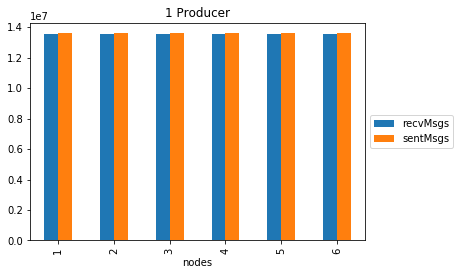

<Figure size 432x288 with 0 Axes>

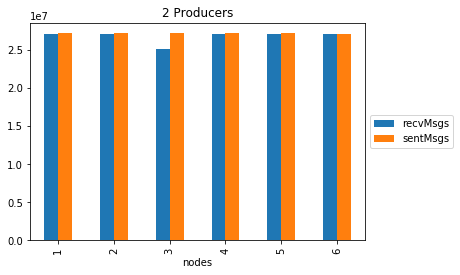

<Figure size 432x288 with 0 Axes>

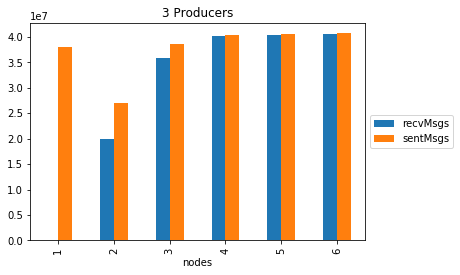

<Figure size 432x288 with 0 Axes>

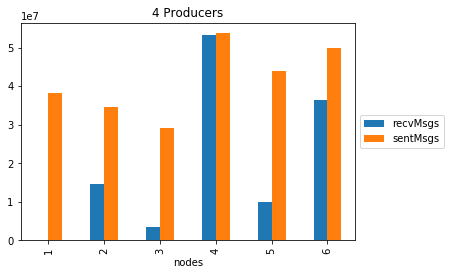

<Figure size 432x288 with 0 Axes>

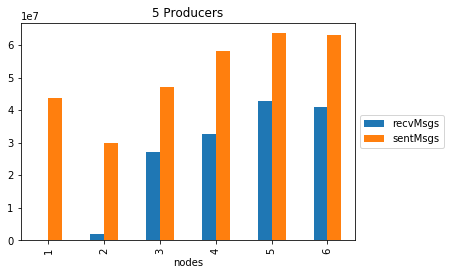

<Figure size 432x288 with 0 Axes>

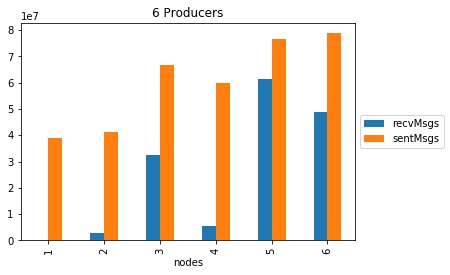

In [6]:
path = './results/'
msgsPerFile = 1

df = getResults(path, msgsPerFile)

### Do more nodes mean more messages processed?

# 1 port 
f = plt.figure()
df1 = df[(df['port']==1) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')
f = plt.gcf()
plt.title('1 Producer', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/1port_allnodes_output.pdf',bbox_inches='tight')

# 2 ports

f = plt.figure()
df1 = df[(df['port']==2) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')
f = plt.gcf()
plt.title('2 Producers', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/2port_allnodes_output.pdf',bbox_inches='tight')

# 3 ports
f = plt.figure()
df1 = df[(df['port']==3) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')
f = plt.gcf()
plt.title('3 Producers', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/3port_allnodes_output.pdf',bbox_inches='tight')

# 4 ports
f = plt.figure()
df1 = df[(df['port']==4) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')
f = plt.gcf()
plt.title('4 Producers', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/4port_allnodes_output.pdf',bbox_inches='tight')


# 5 ports
f = plt.figure()
df1 = df[(df['port']==5) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')
f = plt.gcf()
plt.title('5 Producers', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/5port_allnodes_output.pdf',bbox_inches='tight')

# 6 ports
f = plt.figure()
df1 = df[(df['port']==6) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')
f = plt.gcf()
plt.title('6 Producers', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/6port_allnodes_output.pdf',bbox_inches='tight')

/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

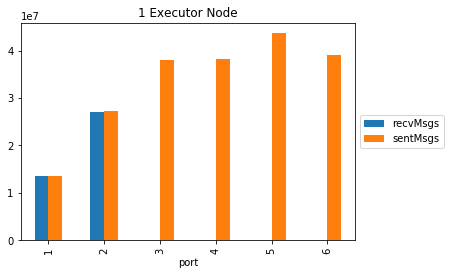

<Figure size 432x288 with 0 Axes>

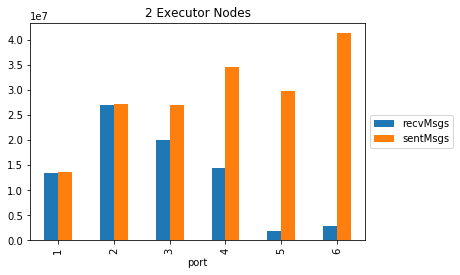

<Figure size 432x288 with 0 Axes>

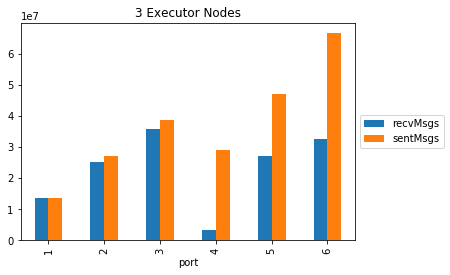

<Figure size 432x288 with 0 Axes>

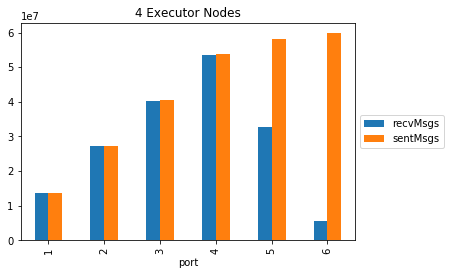

<Figure size 432x288 with 0 Axes>

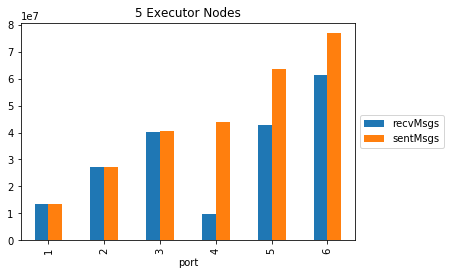

<Figure size 432x288 with 0 Axes>

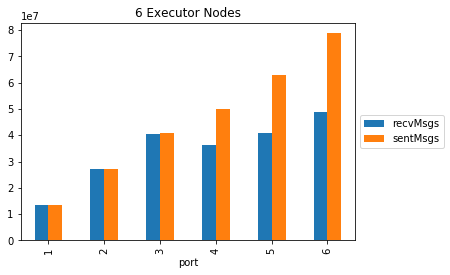

In [7]:
path = './results/'
msgsPerFile = 1

df = getResults(path, msgsPerFile)

# 1 nodes
f = plt.figure()
df1 = df[(df['nodes']==1) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('1 Executor Node', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/1nodes_allports_output.pdf',bbox_inches='tight')

# 2 nodes
f = plt.figure()
df1 = df[(df['nodes']==2) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('2 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/2nodes_allports_output.pdf',bbox_inches='tight')

# 3 nodes
f = plt.figure()
df1 = df[(df['nodes']==3) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('3 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/3nodes_allports_output.pdf',bbox_inches='tight')

# 4 nodes
f = plt.figure()
df1 = df[(df['nodes']==4) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('4 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/4nodes_allports_output.pdf',bbox_inches='tight')

# 5 nodes
f = plt.figure()
df1 = df[(df['nodes']==5) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('5 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/5nodes_allports_output.pdf',bbox_inches='tight')

# 6 nodes
f = plt.figure()
df1 = df[(df['nodes']==6) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('6 Executor Nodes', color='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/6nodes_allports_output.pdf',bbox_inches='tight')

/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


     producers   latency
0   1 producer  1.408524
1  2 producers  1.200823


/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



     producers    latency
0   1 producer   1.263029
1  2 producers   1.592961
2  3 producers   2.964164
3  4 producers   4.791687
4  5 producers   7.340520
5  6 producers  12.181484


/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



     producers    latency
0   1 producer   1.806221
1  2 producers   1.686586
2  3 producers   2.299643
3  4 producers   2.018220
4  5 producers   4.630137
5  6 producers  10.962650


/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/ronnie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/Users/ronnie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

     producers    latency
0   1 producer   1.875831
1  2 producers   1.839106
2  3 producers   2.467327
3  4 producers   5.668371
4  5 producers   3.359951
5  6 producers  11.122036


/Users/ronnie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too m

     producers   latency
0   1 producer  2.101987
1  2 producers  2.289430
2  3 producers  2.947199
3  4 producers  7.351514
4  5 producers  5.618668
5  6 producers  7.078796


/Users/ronnie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too m

     producers    latency
0   1 producer   1.953873
1  2 producers   2.714479
2  3 producers   3.686595
3  4 producers   4.941827
4  5 producers  24.850574
5  6 producers   8.582286


/Users/ronnie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 432x288 with 0 Axes>

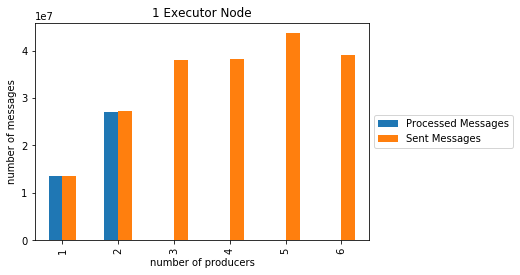

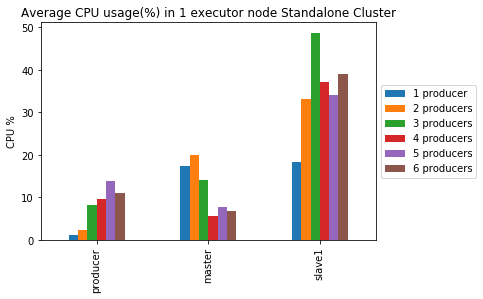

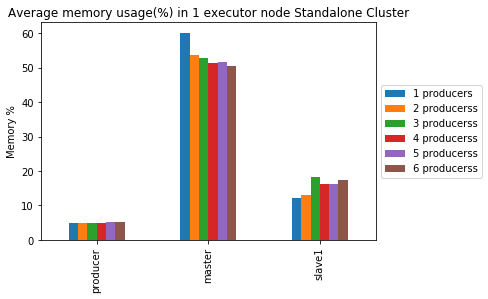

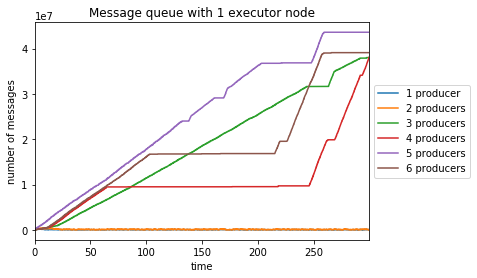

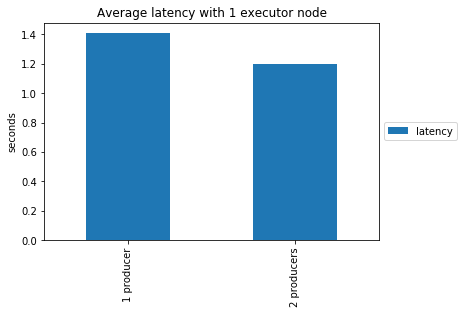

<Figure size 432x288 with 0 Axes>

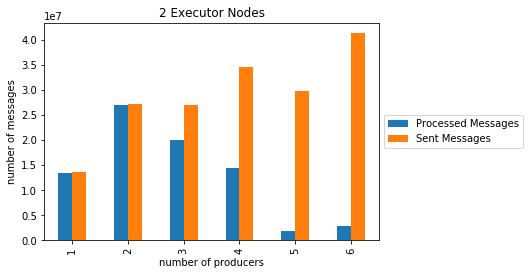

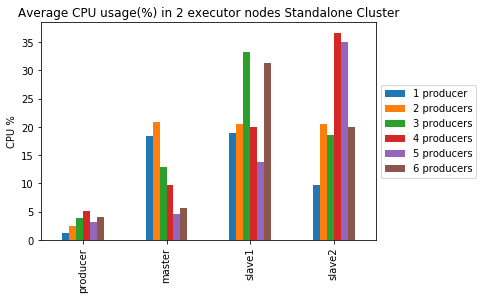

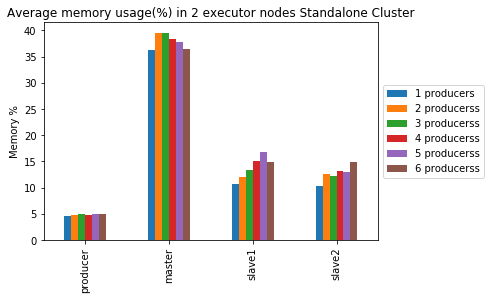

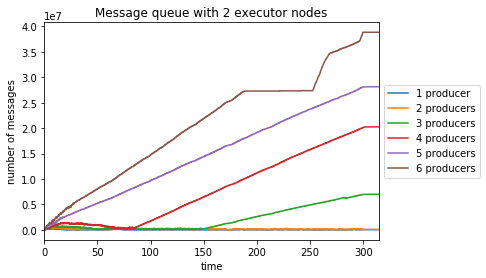

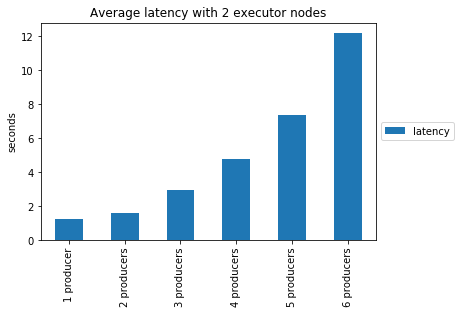

<Figure size 432x288 with 0 Axes>

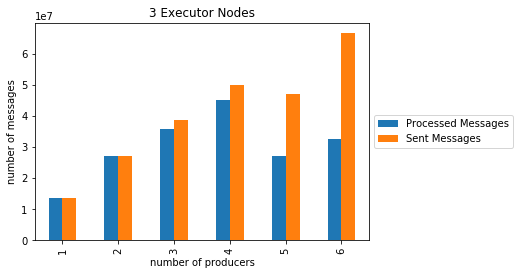

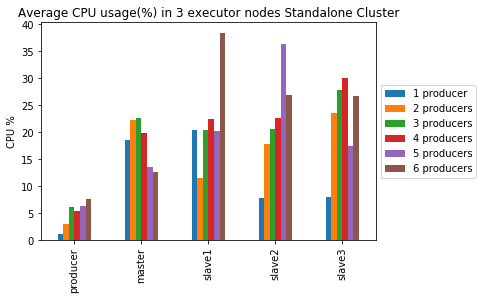

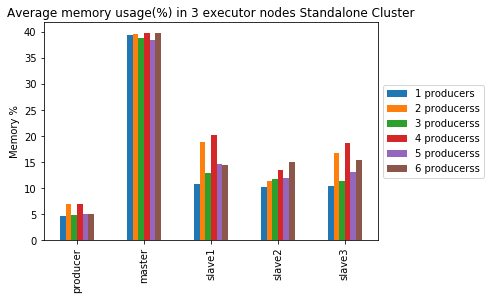

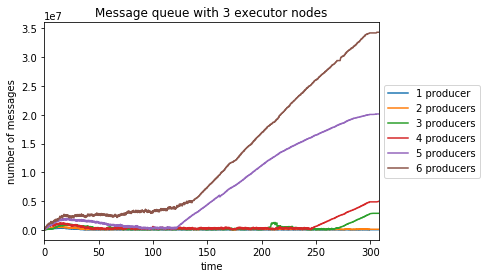

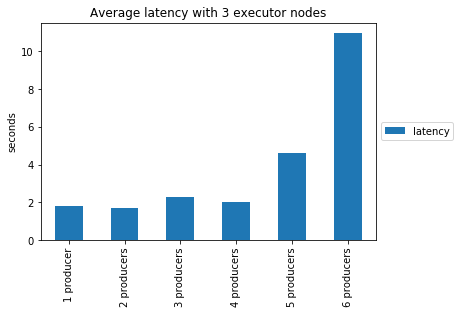

<Figure size 432x288 with 0 Axes>

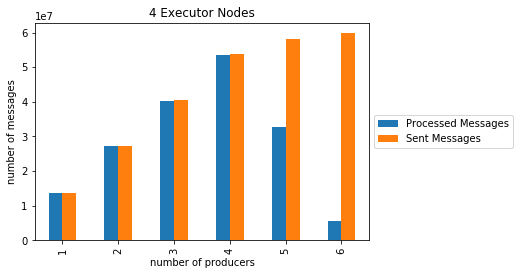

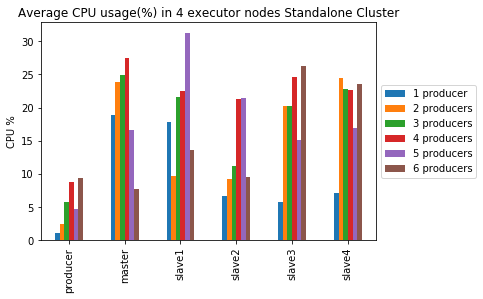

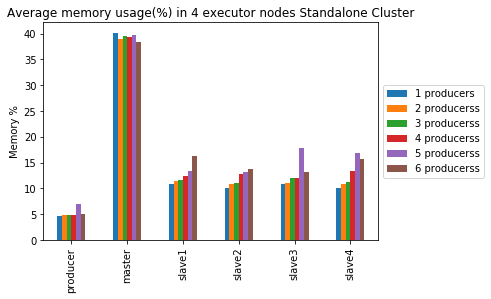

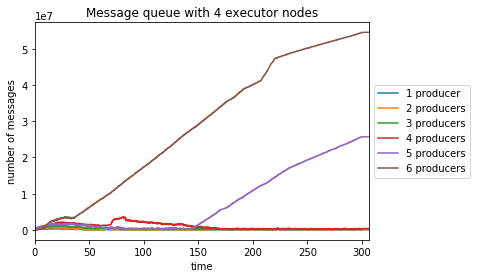

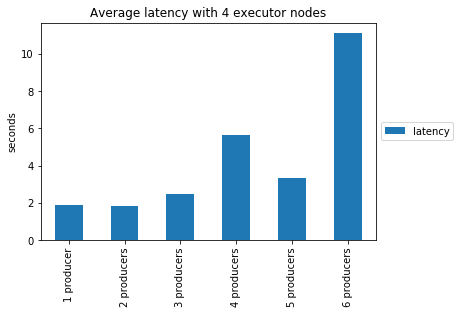

<Figure size 432x288 with 0 Axes>

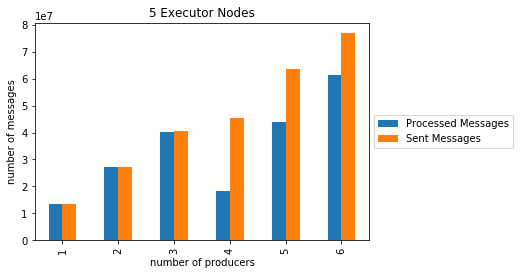

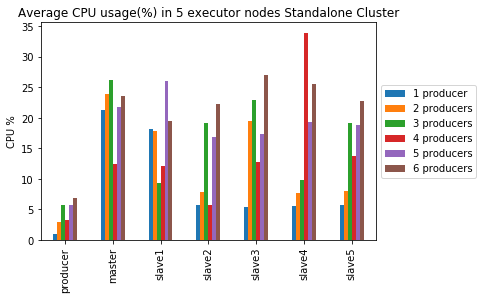

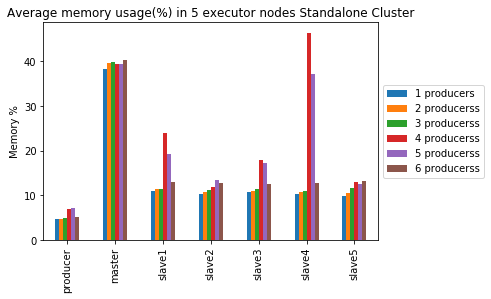

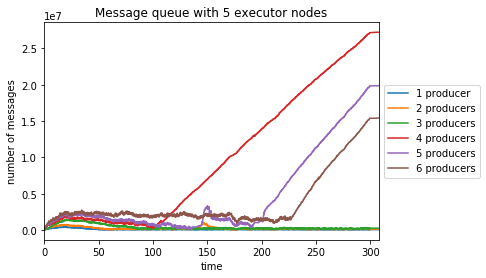

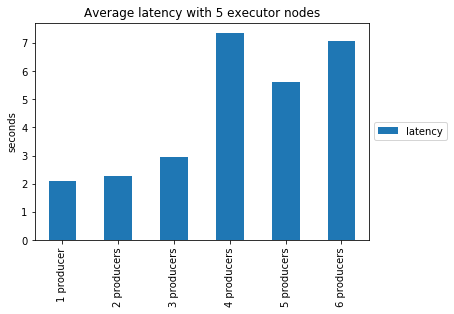

<Figure size 432x288 with 0 Axes>

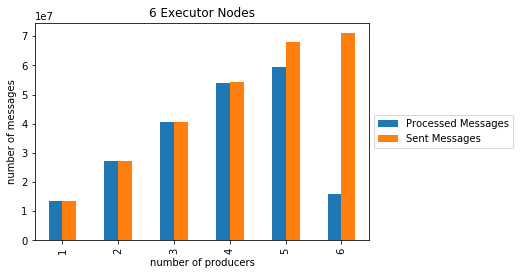

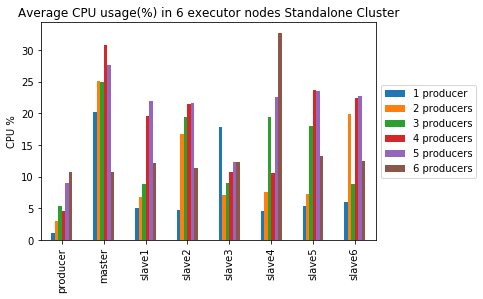

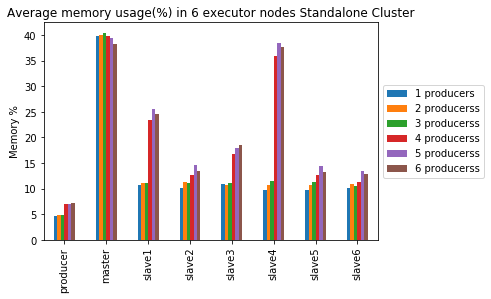

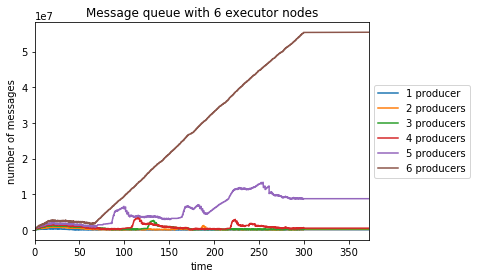

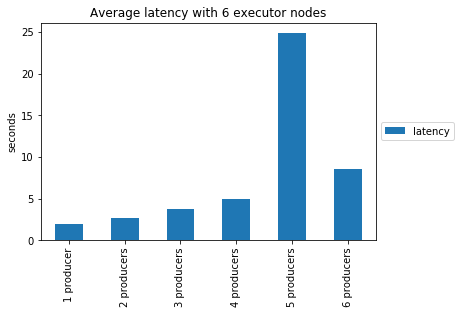

In [61]:
# Post Mortem Results - Scaling out

lst = [1,2,3,4,5,6]

for nodes in lst: 
    path = './results/'
    msgsPerFile = 1
    df = getResults(path, msgsPerFile)

    # Number of messages sent and processed
    f = plt.figure()
    df1 = df[(df['nodes']==nodes) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
    df1.plot.bar(x='port')
    f = plt.gcf()
    plt.title(str(nodes)+' Executor Node'+('s' if nodes>1 else ''), color='black')
    plt.legend(['Processed Messages', 'Sent Messages'], loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('number of messages')
    plt.xlabel('number of producers')
    f.savefig('graphs/'+str(nodes)+'nodes_allports_output.pdf',bbox_inches='tight')

    node = ['producer', 'master', 'slave1', 'slave2','slave3','slave4','slave5','slave6']
    filterList = node[:node.index('slave'+str(nodes))+1]
    # CPU %
    dfResults = pd.DataFrame({'node':node})
    for i in range(1,7):
        cpu = []
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        for j in node:
            df = getMonitorData(path, j)
            cpu.append(df.filter(items=['cpu']).mean()['cpu'])
        dfResults[str(i)+' producer'+('s' if i>1 else '')] = cpu


    dfResults[(dfResults['node'].isin(filterList))].plot.bar(x='node')
    f = plt.gcf()
    plt.title('Average CPU usage(%) in '+str(nodes)+' executor node'+ ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('CPU %')
    plt.xlabel('')
    f.savefig('graphs/'+str(nodes)+'executornode_cpu.pdf',bbox_inches='tight')

    # MEM %
    node = ['producer', 'master', 'slave1', 'slave2','slave3','slave4','slave5','slave6']
    dfResults = pd.DataFrame({'node':node})

    for i in range(1,7):
        mem = []
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        for j in node:
            df = getMonitorData(path, j)
            mem.append(df.filter(items=['mem']).mean()['mem'])
        dfResults[str(i)+' producers'+('s' if i>1 else '')] = mem
    dfResults[(dfResults['node'].isin(filterList))].plot.bar(x='node')
    f = plt.gcf()
    plt.title('Average memory usage(%) in '+str(nodes)+' executor node' + ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('Memory %')
    plt.xlabel('')
    f.savefig('graphs/'+str(nodes)+'executornode_mem.pdf',bbox_inches='tight')


    # Message Queue size
    path = 'results/'+str(nodes)+'_1_300000_2g_1_'
    dfConcat = getQueue(path)
    dfConcat = dfConcat.rename(columns={'queue':'1 producer'})
    for i in range(2,7):
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        df = getQueue(path)
        dfConcat = pd.merge_ordered(dfConcat,df,on='time',fill_method='ffill').fillna(0)
        dfConcat = dfConcat.rename(columns={'queue':str(i)+' producers'})

    dfConcat['time'] = dfConcat['time']*10**(-9)
    dfConcat.plot(x='time')
    f = plt.gcf()
    plt.title('Message queue with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('number of messages')
    f.savefig('graphs/'+str(nodes)+'executornode_queue.pdf',bbox_inches='tight')

    # Latency Calculation
    producers = ['1 producer', '2 producers', '3 producers', '4 producers', '5 producers', '6 producers']
    avgLatency = []
    for i in range(1,7):
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        avgLatency.append(getLatency(path))

    df = pd.DataFrame({'producers':producers, 'latency':avgLatency})
    print(df.dropna())
    df.dropna().plot.bar(x='producers')
    f = plt.gcf()
    plt.title('Average latency with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('seconds')
    plt.xlabel('')
    f.savefig('graphs/'+str(nodes)+'executornode_latency.pdf',bbox_inches='tight')


/Users/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



FileNotFoundError: [Errno 2] No such file or directory: 'results/3_4_300000_4g_1_/logSpark.txt'

<Figure size 432x288 with 0 Axes>

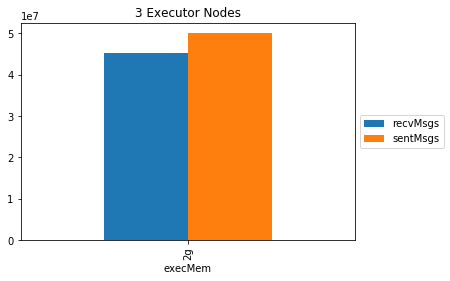

In [24]:
# Post Mortem Results - Scaling out

nodes = 3
ports = 4

path = './results/'
msgsPerFile = 1
df = getResults(path, msgsPerFile)

# number of messages

f = plt.figure()
df1 = df[(df['nodes']==nodes) & (df['port']==ports) & (df['version']==0)].sort_values(by='execMem').filter(items=['execMem','recvMsgs','sentMsgs'])
df1['execIndex'] = [int(i[:len(i)-1]) for i in df1['execMem']]
df1 = df1.sort_values(by='execIndex').filter(items=['execMem','recvMsgs','sentMsgs'])
df1.plot.bar(x='execMem')
f = plt.gcf()
plt.title(str(nodes)+' Executor Node'+('s' if nodes>1 else ''), color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'nodes_scaling_out_'+str(ports)+'ports.pdf',bbox_inches='tight')

# CPU%

node = ['producer', 'master', 'slave1', 'slave2','slave3','slave4','slave5','slave6']
filterList = node[:node.index('slave'+str(nodes))+1]
execMem = ['2g', '4g', '8g', '12g']
# CPU %
dfResults = pd.DataFrame({'node':node})
for i in execMem:
    cpu = []
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    for j in node:
        df = getMonitorData(path, j)
        cpu.append(df.filter(items=['cpu']).mean()['cpu'])
    dfResults[str(i)] = cpu


dfResults[(dfResults['node'].isin(filterList))].plot.bar(x='node')
f = plt.gcf()
plt.title('Average CPU usage(%) in '+str(nodes)+' executor node'+ ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'executornode_cpu.pdf',bbox_inches='tight')

# MEM%

node = ['producer', 'master', 'slave1', 'slave2','slave3','slave4','slave5','slave6']
dfResults = pd.DataFrame({'node':node})

for i in execMem:
    mem = []
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    for j in node:
        df = getMonitorData(path, j)
        mem.append(df.filter(items=['mem']).mean()['mem'])
    dfResults[i] = mem
dfResults[(dfResults['node'].isin(filterList))].plot.bar(x='node')
f = plt.gcf()
plt.title('Average memory usage(%) in '+str(nodes)+' executor node' + ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'executornode_mem.pdf',bbox_inches='tight')

# Queue length

path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+execMem[0]+'_1_'
dfConcat = getQueue(path)
dfConcat = dfConcat.rename(columns={'queue':execMem[0]})
for i in execMem[1:]:
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    df = getQueue(path)
    dfConcat = pd.merge_ordered(dfConcat,df,on='time',fill_method='ffill').fillna(0)
    dfConcat = dfConcat.rename(columns={'queue':i})
    
dfConcat['time'] = dfConcat['time']*10**(-9)
dfConcat.plot(x='time')
f = plt.gcf()
plt.title('Message queue with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'executornode_'+str(ports)+'_scaleout_queue.pdf',bbox_inches='tight')


# Latency Calculation
avgLatency = []
for i in execMem:
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    avgLatency.append(getLatency(path))

df = pd.DataFrame({'execMem':execMem, 'latency':avgLatency})
print(df.dropna())
df.dropna().plot.bar(x='execMem')
f = plt.gcf()
plt.title('Average latency with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'executornode_'+str(ports)+'_scaleout_latency.pdf',bbox_inches='tight')




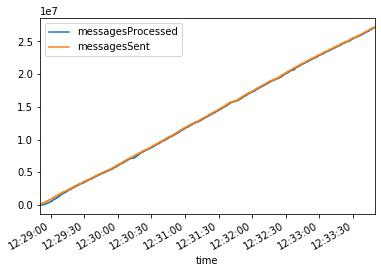

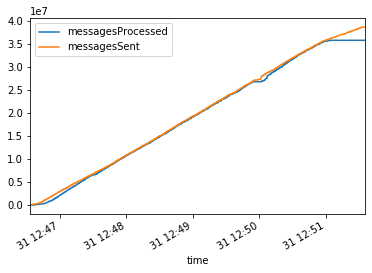

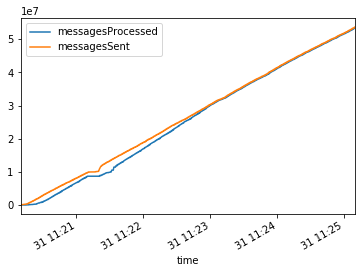

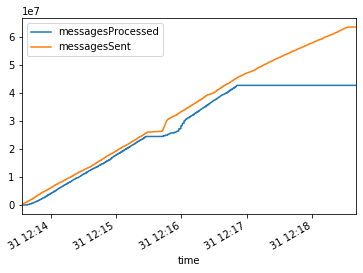

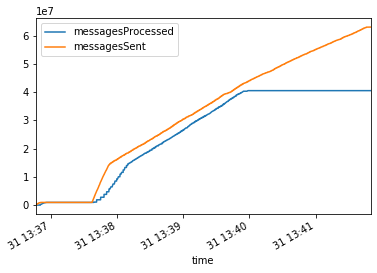

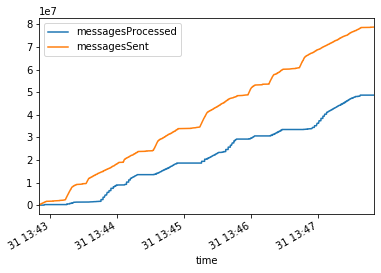

In [10]:
path = 'results/2_2_300000_2g_1_'
getProcessingResults(path).plot(x='time')

path = 'results/3_3_300000_2g_1_'
getProcessingResults(path).plot(x='time')

path = 'results/4_4_300000_2g_1_'
getProcessingResults(path).plot(x='time')

path = 'results/5_5_300000_2g_1_'
getProcessingResults(path).plot(x='time')

path = 'results/6_5_300000_2g_1_'
getProcessingResults(path).plot(x='time')

path = 'results/6_6_300000_2g_1_'
getProcessingResults(path).plot(x='time')




mem    6.3
dtype: float64


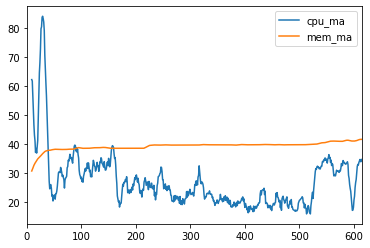

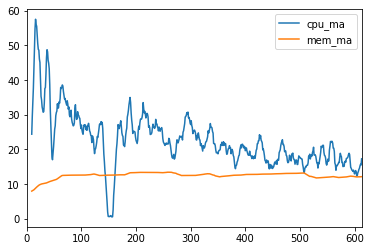

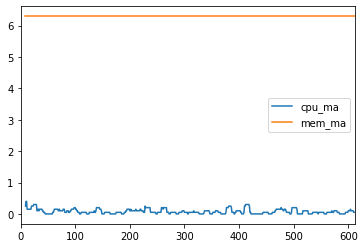

In [11]:
# pick a folder
path = 'results/4_4_300000_2g_1_'

df = getMonitorData(path, 'master')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])

df = getMonitorData(path, 'slave1')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])

df = getMonitorData(path, 'slave6')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

print(df.filter(items=['mem']).mean())

df.plot(y=['cpu_ma','mem_ma'])